<a href="https://colab.research.google.com/github/Cumberkid/Learning-the-Optimal-Solution-Path/blob/main/experiments/fair-regression/notebooks/06%20Naive%20Grid%20Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader  #for creating the dataset


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
# import importlib

## Import our own modules

In [ ]:
# !rm -r Learning-the-Optimal-Solution-Path
!git clone https://github.com/Cumberkid/Learning-the-Optimal-Solution-Path.git

Cloning into 'Learning-the-Optimal-Solution-Path'...
remote: Enumerating objects: 542, done.
remote: Counting objects: 100% (352/352), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 542 (delta 199), reused 180 (delta 105), pack-reused 190
Receiving objects: 100% (542/542), 10.99 MiB | 24.96 MiB/s, done.
Resolving deltas: 100% (295/295), done.


(Using Colab)

In [ ]:
import sys

In [ ]:
# Add the parent directory to sys.path
sys.path.append('/content/Learning-the-Optimal-Solution-Path')

In [ ]:
import lib
# importlib.reload(lib)

In [ ]:
from lib.utils_data import Regression_Data
from lib.ngs.naive_grid_search import naive_grid_search
from lib.ngs.utils_ngs import get_sup_error

# Load data

In [ ]:
# file path for Colab. May need to change this
X_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/X_processed.csv')
y_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/y_processed.csv')

In [ ]:
X = np.array(X_df)
y = np.array(y_df).squeeze()

In [ ]:
full_data = Regression_Data(X, y)
# full gradient descent uses all data points
GD_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(full_data, batch_size=20, shuffle=True, )
# test data
test_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=False, )

In [ ]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]
criterion=torch.nn.BCELoss()

# Naive Grid Search

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time

# Exact Gradient Oracle Constant LR

Use the previously tuned lr = 2.

In [ ]:
lam_max = 1
lam_min = 0
lr = 2
max_epochs = 5000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** np.arange(3, 9, 0.2)

In [ ]:
total_itr_list = []
sup_error_list = []
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = round(10 / np.sqrt(delta))

    start_time = time.time()
    total_itr, reg_params, intercepts, weights = naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                trainDataLoader=GD_data_loader,
                                data_input_dim=input_dim, obj='fairness',
                                lr=lr, SGD=False, testDataLoader=test_data_loader,
                                true_loss_list=true_losses, stopping_criterion=delta)

    end_time = time.time()
    execution_time = end_time - start_time

    total_itr_list.append(total_itr)

    sup_error = get_sup_error(lam_min, lam_max, true_losses, intercepts,
                                  weights, reg_params, test_data_loader, criterion, obj='fairness')

    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")

total_itr_list = np.array(total_itr_list)
sup_error_list = np.array(sup_error_list)

grid #: 28	 total iteration #: 280	 sup error: 0.1113289073109627	 Execution time: 4.930688858032227 seconds
grid #: 30	 total iteration #: 300	 sup error: 0.10846743732690821	 Execution time: 4.830096960067749 seconds
grid #: 32	 total iteration #: 320	 sup error: 0.10319911688566209	 Execution time: 5.339426755905151 seconds
grid #: 35	 total iteration #: 350	 sup error: 0.09907814860343937	 Execution time: 6.709510564804077 seconds
grid #: 37	 total iteration #: 370	 sup error: 0.09513391554355624	 Execution time: 6.984997749328613 seconds
grid #: 40	 total iteration #: 400	 sup error: 0.090820286422968	 Execution time: 7.541378021240234 seconds
grid #: 43	 total iteration #: 440	 sup error: 0.06058480218052872	 Execution time: 8.763097047805786 seconds
grid #: 46	 total iteration #: 470	 sup error: 0.05893441289663324	 Execution time: 8.892436504364014 seconds
grid #: 49	 total iteration #: 520	 sup error: 0.0589468628168107	 Execution time: 10.050185918807983 seconds
grid #: 53	 t

In [ ]:
df = pd.DataFrame(np.column_stack((total_itr_list, sup_error_list)), columns=['num_itr', 'sup_err'])

# Save the DataFrame to a CSV file
df.to_csv('NGS_results_exact.csv', index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv('NGS_results_exact.csv')

In [ ]:
# import csv

# csv_file_path = '/content/drive/MyDrive/Experiments/NGS_results_exact.csv'

# # Open the CSV file for writing
# with open(csv_file_path, 'w', newline='') as csv_file:
#     # Create a CSV writer
#     csv_writer = csv.writer(csv_file)

#     # Write the headers
#     csv_writer.writerow(['num_itr', 'sup_err'])

#     # Write the data from your lists
#     for i in range(len(total_itr_list)):
#         csv_writer.writerow([total_itr_list[i], sup_error_list[i]])

In [ ]:
# for i in range(len(sup_error_list)):
#     sup_error_list[i] = np.min(sup_error_list[:i+1])

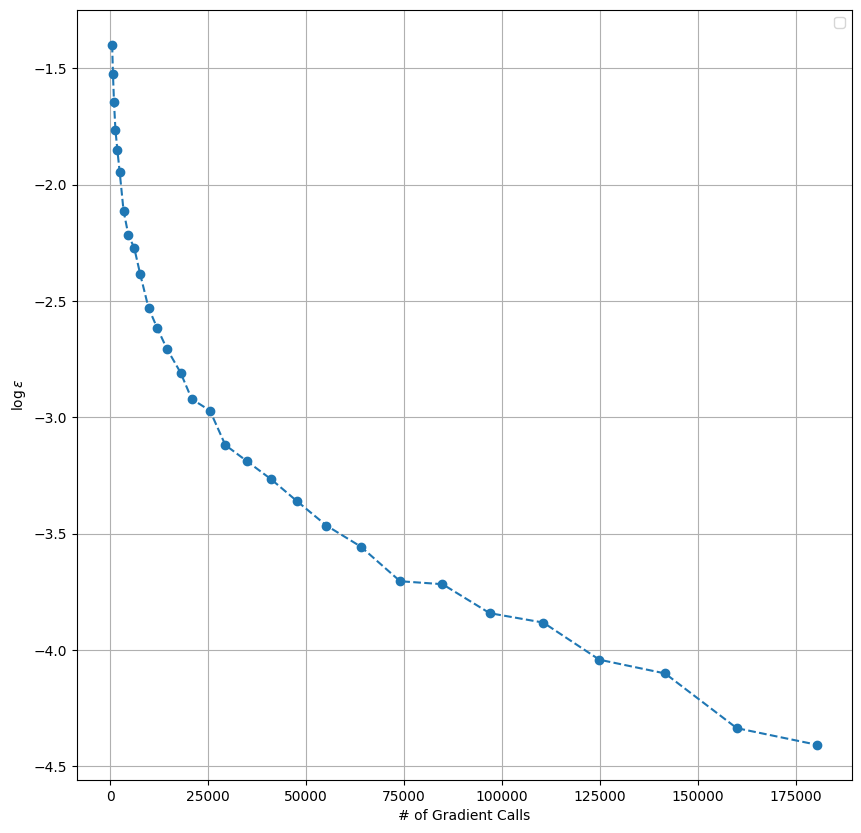

In [ ]:
# plot result of learning the solution path
plt.figure(figsize=(10,10))
plt.plot(total_itr_list, np.log(sup_error_list), '--o')
plt.xlabel('# of Gradient Calls')
plt.ylabel('$\\log\\epsilon$')
plt.legend()
plt.grid(True)

# Noisy Gradient Oracle Diminishing LR

Use the previously tuned diminishing factor $\alpha = 8$ where lr = $\alpha/T$.

In [ ]:
lam_max = 1
lam_min = 0
alpha = 2**3
max_epochs = 5000
# a list of solution accuracy delta wish to be achieved
delta_list = 0.5 ** np.arange(3, 7, 0.125)

In [ ]:
total_itr_list = []
sup_error_list = []
np.random.seed(8675309)
torch.manual_seed(8675309)
for delta in delta_list:
    # number of grids according to 1/sqrt(delta)
    num_grid = round(10 / np.sqrt(delta))

    start_time = time.time()
    total_itr, reg_params, intercepts, weights = naive_grid_search(lam_min=lam_min, lam_max=lam_max,
                                num_grid=num_grid, epochs=max_epochs, loss_fn=criterion,
                                trainDataLoader=SGD_data_loader, data_input_dim=input_dim, obj='fairness',
                                alpha=alpha, init_lr = 1, SGD=True, testDataLoader=test_data_loader,
                                true_loss_list=true_losses, stopping_criterion=delta)

    end_time = time.time()
    execution_time = end_time - start_time

    total_itr_list.append(total_itr)

    sup_error = get_sup_error(lam_min, lam_max, true_losses, intercepts,
                                  weights, reg_params, test_data_loader, criterion, obj='fairness')

    sup_error_list.append(sup_error)

    print(f"grid #: {num_grid}\t total iteration #: {total_itr}\t sup error: {sup_error}\t Execution time: {execution_time} seconds")

total_itr_list = np.array(total_itr_list)
sup_error_list = np.array(sup_error_list)

grid #: 28	 total iteration #: 340	 sup error: 0.12806227803230294	 Execution time: 58.33738088607788 seconds
grid #: 30	 total iteration #: 380	 sup error: 0.11760282516479492	 Execution time: 59.871182441711426 seconds
grid #: 31	 total iteration #: 370	 sup error: 0.09389710426330569	 Execution time: 57.774436712265015 seconds
grid #: 32	 total iteration #: 370	 sup error: 0.0984701961278916	 Execution time: 60.3169903755188 seconds
grid #: 34	 total iteration #: 430	 sup error: 0.09169669449329376	 Execution time: 71.76477837562561 seconds
grid #: 35	 total iteration #: 490	 sup error: 0.08168046176433572	 Execution time: 81.55543899536133 seconds
grid #: 37	 total iteration #: 510	 sup error: 0.07611775398254395	 Execution time: 85.14778065681458 seconds
grid #: 38	 total iteration #: 590	 sup error: 0.07992149144411095	 Execution time: 98.72878527641296 seconds
grid #: 40	 total iteration #: 620	 sup error: 0.06609161198139196	 Execution time: 99.22847747802734 seconds
grid #: 42

In [ ]:
df = pd.DataFrame(np.column_stack((total_itr_list, sup_error_list)), columns=['num_itr', 'sup_err'])

# Save the DataFrame to a CSV file
df.to_csv('NGS_results_noisy.csv', index=False)

# Read the CSV file into a DataFrame
df = pd.read_csv('NGS_results_noisy.csv')

In [ ]:
# # plot result of learning the solution path
# plt.figure(figsize=(10,10))
# plt.plot(total_itr_list, np.log(sup_error_list), '--o', )
# plt.ylabel('# of Gradient Calls')
# plt.xlabel('$\\log\\epsilon$')
# plt.legend()
# plt.grid(True)